# Проект для "Викишоп"

## Описание проекта

- Интернет - магазин "Викишоп" запускает новый сервис
- У пользователей есть возможность добавлять комментировать товары, правки и любые измнения
- Требуется инструмент, который будет находить токсичные комментарии и отправлять их на модерацию

## Цель работы

- Разработать модель, которая будет находить токсичные комментарии
- Добиться значения метрики `f1` более 0.75

## План работы

  1. Загрузка и подготовка данных
  2. Обучение моделей
  3. Выводы

## Описание данных

- В датасете присутствует 2 признака:
    + `text` - столбец с текстом комментариев пользователей
    + `toxic` - столбец, содержащий целевой признак

# Шаг 1.1 Загрузка данных

- Загрузка нужных версий библиотек

In [ ]:
!pip install -q scikit-learn
!pip install -q torch
!pip install -q transformers
!pip install -q nltk
!pip install -q catboost
!pip install -q re
!pip install -q spacy
#import sys
#!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
#!{sys.executable}
#-m spacy download en_core_web_sm


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


- Загрузка инструментов

In [ ]:
# Библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import transformers
import re
import nltk
import warnings
import lightgbm as lgb
import catboost
import spacy
import tqdm
nltk.download('stopwords')
#Инструменты из библиотек
from catboost import CatBoostClassifier
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from spacy.lang.en.examples import sentences
from sklearn.feature_extraction.text import (CountVectorizer, TfidfVectorizer, TfidfTransformer)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.metrics import (accuracy_score, f1_score)
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Игнорирование предупреждений
warnings.filterwarnings('ignore')

In [ ]:
# Константы
RANDOM_STATE = 777
TEST_SIZE = 0.2

- Загрузим датасет

In [ ]:
comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col = 0)

In [ ]:
comments.shape

(159292, 2)

In [ ]:
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


- приведём слова к нижнему регистру

In [ ]:
comments['text'] = comments['text'].apply(lambda x: x.lower())

In [ ]:
comments.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


# Шаг 1.2 Подготовка данных

- Произведём токенизацию и лемматизацию текста, используя SpaCy
- Для этого напишем функцию

In [ ]:
# Функиця для построения одной круговой диаграммы
def pie_build_one(df, column, support_column, title):
    df_column = df.pivot_table(index = column, values = support_column, aggfunc = ['count'])
    df_column.columns = ['quantity']
    df_column['quantity'] = df_column['quantity'] / df[column].count()
    ax.set_title(title);
    ax.pie(df_column['quantity'], autopct='%1.2f%%');
    ax.legend(
    bbox_to_anchor = (1.0, 1.0),
    loc = 'upper left', labels = df_column.index);

In [ ]:
# Функция для токенизации и лемматизации методом SpaCy
def spacy_token_and_lemma(text):
    doc = nlp(text)
    return(" ".join([token.lemma_ for token in doc]))


- Удалим символы, которые не имеют отношения к английскому языку

In [ ]:
comments['text'] = comments['text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

In [ ]:
comments.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m s...,0
2,hey man i m really not trying to edit war it...,0
3,more i can t make any real suggestions on im...,0
4,you sir are my hero any chance you remember...,0


- Тестирование SpaCy для проверки правильности лемматизации

In [ ]:
# Инициализируем Spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
sentence_1 = "you should be ashamed of yourself went worked"
sentence_2 = "The striped bats are hanging on their feet for best"
df_test = pd.DataFrame([sentence_1, sentence_2], columns = ['text'])

In [ ]:
tqdm.pandas()
print(df_test['text'].progress_apply(lambda x: spacy_token_and_lemma(x)))

  0%|          | 0/2 [00:00<?, ?it/s]

0        you should be ashamed of yourself go work
1    the stripe bat be hang on their foot for good
Name: text, dtype: object


- Теперь используем SpaCy на датасете

In [ ]:
comments.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m s...,0
2,hey man i m really not trying to edit war it...,0
3,more i can t make any real suggestions on im...,0
4,you sir are my hero any chance you remember...,0


In [ ]:
tqdm.pandas()
comments['text'] = comments['text'].progress_apply(lambda x: spacy_token_and_lemma(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

- Сохраним файл с лемматизированным текстом, чтобы не тратить время на его лемматизацию при последующих запусках проекта

In [ ]:
#comments.to_csv('comments_lemma.csv')

- Загружаем файл с лемматизированным текстом

In [ ]:
#comments = pd.read_csv('comments_lemma.csv', index_col = 0)

In [ ]:
comments.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m se...,0
2,hey man I m really not try to edit war it ...,0
3,more I can t make any real suggestion on im...,0
4,you sir be my hero any chance you rememb...,0


- Файл прочитан, данные не утеряны
- Стоп - слова будут удалены в пайплайне при использовании векторизации текста

- Построим круговую диаграмму для анализа отношения числа нейтральных и негативных комментариев

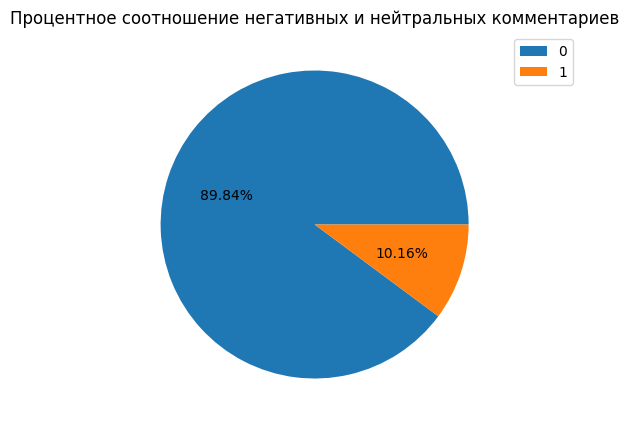

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))
pie_build_one(comments, 'toxic', 'text', 'Процентное соотношение негативных и нейтральных комментариев')

# Шаг 2. Обучение моделей

- Создадим пайплайн, в котором произведём кодирование текста при помощи `CountVectorizer` и `TfidfVectorizer`
- В качестве моделей МО, воспользуемся `логистической регрессией`, `деревом классификации` и `CatBoost`
- Для автоматизированного поиска лучшей модели применим `GridSearchCV`
- Оценивать качество работы модели будем при помощи метрики `f1`, так как она сбалансирована и даёт представление в целом о точности и полноте предсказаний(также потому как эта метрика должна быть использована по условию проекта)

- Разобьём датасет на входные признаки `corpus` (text) и целевой признак `target` (toxic)

In [ ]:
#comments = comments.sample(frac = 0.4, random_state = RANDOM_STATE)

In [ ]:
corpus = comments['text']

In [ ]:
target = comments['toxic']

- Установление стоп - слов

In [ ]:
stop_words = set(stopwords.words('english'))

- Разделим комментарии на обучающую и тестовую выборку

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(corpus, target, test_size = TEST_SIZE, random_state = RANDOM_STATE)

- Для автоматизации поиска лучшей модели воспользуемся GridSearchCV

In [ ]:
# Гиперпараметры моделей
param_grid = [
            {
                #Логистическая регрессия
                'models': [LogisticRegression(random_state = RANDOM_STATE)],
                'models__penalty' : ['l2'],
                'models__C' : [3, 5, 10, 15],
                'models__solver' : ['liblinear', 'newton-cholesky', 'sag', 'saga', 'newton-cg'] ,
                'models__max_iter' : [3000]
            },
#            {
                #Дерево классификации
#                'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
#                'models__max_depth' : range(10, 15),
#                'models__min_samples_split' : range(10, 15),
#                'models__max_leaf_nodes' : range(45, 50)
#            },
            {
                #Логистическая регрессия
                'models': [LogisticRegression(random_state = RANDOM_STATE)],
                'models__C' : [3, 5, 10, 15],
                'models__solver' : ['sag', 'saga', 'newton-cg'] ,
                'models__max_iter' : [3000]
            }
#            {
                #CatBoost
#                'models' : [CatBoostClassifier(random_state = RANDOM_STATE)],
#                'models__max_depth' : [8, 13],
#                'models__iterations' : [20, 30],
#                'models__learning_rate' : [0.03],
#            }
]

- Гиперпараметры `Логистической регресии`:
    + Сперва определимся с солверами, а именно выбираем 'liblinear' и 'newton-cholesky'. Эти алгоритмы адаптрованы для работы с большими объёмами данных, что актуально для поставленной задачи
    + С данными типами солверов совместима только l2 - регуляризация, поэтому выбираем её
    + Введём также изменяемое значение штрафов за переобучение для общего представления о работе модели
    + Добавим также другие солверы, не указывая вид регуляризации, т.к. может возникнуть конфликт при обучение из - за особенностей совместимости регуляризации и солверов

- Гиперпараметры `DecisionTreeClassifier`:
    + В данном случае выбираем несколько параметров и смотрим на результат. Определённого принципа при подборе параметров не использовалось кроме тех, что закладываются моделью изначально
    + В ходе нескольких запусков проекта было выяснено, что DecisionTreeClassifier не даёт высоких результатов

+ Гиперпараметры `CatBoost`:
    - Для модели CatBoost выбираем max_depth < 16, так как это требование самой библиотеки
    - Число итераций выбираем равным от 20 до 30, чтобы время обучения было минимальным
    - Какие - то другие параметры не имеет  смысла менять, так как данная модель является градиентным бустингом и на каждом последующем этапе она совершенствуется. В течение 20 - 30 итераций этот процесс достигнет требуемых характеристик

+ Комментарии к работе пайплайна, выявленные в ходе нескольких запусков:
    - Обучение моделью `Catboost` закомментировал, так как оно сильно затягивается, а результат хуже, чем у логистической регресии
    - DecisionTreeClassifier не даёт высоких результатов, поэтому тоже закомментировал с целью экономии времени

In [ ]:
# Структура пайплайна
pipe_final = Pipeline([
#    ('vect', CountVectorizer(min_df = 40, ngram_range=(1, 1), stop_words = list(stop_words))),
    ('tfidf', TfidfVectorizer(ngram_range = (1, 1), stop_words = list(stop_words))),
    ('models', LogisticRegression(random_state = RANDOM_STATE))
])

In [ ]:
# Автоматизированный поиск лучшей модели GridSearchCV
grid = GridSearchCV(pipe_final,
                    param_grid = param_grid,
                    cv = 5,
                    scoring = 'f1',
                    n_jobs = -1,
                    verbose = 3000
                   )

- Поиск лучшей модели

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['being',
                                                                    'ma',
                                                                    'your', 'd',
                                                                    'because',
                                                                    'if', 'i',
                                                                    'down',
                                                                    "didn't",
                                                                    'a',
                                                                    'herself',
                                                                    've',
                                                                    'shouldn',
                                                                    'them',
                                                                    'own',
                                                                    'don',
                                                                    'ain', 'am',
                                                                    'was',
                                                                    'before',
                                                                    'few',
                                                                    "doesn't",
                                                                    'hasn',
                                                                    'won',
                                                                    'under',
                                                                    "hadn't",
                                                                    'with',
                                                                    'doesn',
                                                                    'did',
                                                                    "haven't", ...])),
                                       ('models',
                                        LogisticRegression(random_state=777))]),
             n_...
             param_grid=[{'models': [LogisticRegression(random_state=777)],
                          'models__C': [3, 5, 10, 15],
                          'models__max_iter': [3000], 'models__penalty': ['l2'],
                          'models__solver': ['liblinear', 'newton-cholesky',
                                             'sag', 'saga', 'newton-cg']},
                         {'models': [LogisticRegression(random_state=777)],
                          'models__C': [3, 5, 10, 15],
                          'models__max_iter': [3000],
                          'models__solver': ['sag', 'saga', 'newton-cg']}],
             scoring='f1', verbose=3000)

In [ ]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['being', 'ma', 'your', 'd',
                                             'because', 'if', 'i', 'down',
                                             "didn't", 'a', 'herself', 've',
                                             'shouldn', 'them', 'own', 'don',
                                             'ain', 'am', 'was', 'before',
                                             'few', "doesn't", 'hasn', 'won',
                                             'under', "hadn't", 'with', 'doesn',
                                             'did', "haven't", ...])),
                ('models',
                 LogisticRegression(C=15, max_iter=3000, random_state=777,
                                    solver='liblinear'))])


In [ ]:
print('Метрика f1 для лучшей модели на тренировочной выборке:', round((grid.best_score_), 3))

Метрика f1 для лучшей модели на тренировочной выборке: 0.778


In [ ]:
best_estimator = grid.best_estimator_
predictions = best_estimator.predict(X_test)

In [ ]:
print('Метрика f1 лучшей модели на тестовой выборке выборке:', round(f1_score(y_test, predictions), 3))

Метрика f1 лучшей модели на тестовой выборке выборке: 0.783


- В результате обучения лучшей модели были достигнуты значения метрики `f1`:
    + На тренировочной : 0.778
    + На тестовой : 0.783
- Данные показатели удовлетворяют поставленному условию значение метрики более 0.75

# Шаг 3. Общие выводы

- В разработке модели для поиска токсичных комментариев были применены токенизация и лемматизация текстов, а затем пайплайн с моделями МО `LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`
- В результате нескольких запусков и изменений гиперпараметров лучшей оказалась логистическая регрессия с линейном ядром и максимальным значением С(минимальным среди других моделей штрафом за переобучение)
- Причём время обучения логистической регрессией минимально, что является ещё одним преимуществом данной модели
- Если анализировать результаты работы модели, то неудивительно, что лучшей оказалась логистическая регрессия с линейным ядром. Потому как в n - мерном пространстве признаков намного легче провести разделяющую "плоскость", чем бесконечно корректировать разделение при помощи градиентного бустинга или выстраивания большого числа условий в дереве классификации
- Значение метрики `f1` составляет 0.783